# Who Is the Working Class?

<a id="table-of-contents"></a>

## Table of Contents

1. [Introduction](#introduction)
2. [Data Exploration (Temporary Section)](#data-exploration-temporary-section)
3. [Cleaning and Sampling (Temporary Section)](#cleaning-and-sampling-temporary-section)
4. [Processing of a Single Article](#processing-of-a-single-article)
5. [Plots of NYT Sample Results](#plots-of-nyt-sample-results)
6. [Comparison with Other Publishers](#comparison-with-other-publishers)
7. [Next Steps](#next-steps)
8. [Troubleshooting](#troubleshooting)

<a id="introduction"></a>
## 1. Introduction 


[⬆ Return to Top](#table-of-contents)

(Brief overview of the notebook’s purpose, methods, and data sources.)




<a id="data-exploration-temporary-section"></a>

## 2. Data Exploration (Temporary Section)

[⬆ Return to Top](#table-of-contents)

In [1]:
import pandas as pd

df = pd.read_csv('data/categorized_dataset.csv')

In [2]:
df.shape

(41056, 14)

In [3]:
df.head(2)

,title,date,section,length,body,source_file,publisher,publish_date,edition,section_info,author,url,body_cleaned,year
0,The New York Times,September 01st 2024,Section A; Column 0; National Desk; Pg. 15,6500,democrats hoped lose less blue-collar areas dr...,1.DOCX,The New York Times,"November 19, 2024",Late Edition - Final,Section A; Column 0; National Desk; Pg. 15,Katie Glueck,https://www.nytimes.com/2024/11/18/us/politics...,democrats hoped to lose by less in blue-collar...,2024.0
1,A Real Working-Class Hero,"December 13, 2024",Section A; Column 0; Editorial Desk; Pg. 25,628,one more moving stories account life brian tho...,1.DOCX,The New York Times,"December 13, 2024",Late Edition - Final,Section A; Column 0; Editorial Desk; Pg. 25,Bret Stephens,https://www.nytimes.com/live/2024/12/04/opinio...,one of more moving stories in times this week ...,2024.0


In [4]:
from datetime import datetime

# List of possible date formats to try
formats = [
    "%B %d, %Y",   # November 19, 2024
    "%b %d, %Y",   # Jul 24, 2002
    "%Y-%m-%d",    # 2024-11-19
    "%d %B %Y",    # 19 November 2024
    "%m/%d/%Y",    # 07/24/2002
    "%d-%m-%Y"     # 24-07-2002
]

# Function that tries to parse with each format
def try_parse_date(date_str):
    for fmt in formats:
        try:
            return datetime.strptime(date_str, fmt)
        except (ValueError, TypeError):
            continue
    return pd.NaT  # Return Not-a-Time if all formats fail

# Apply the function to the Series
parsed_dates = df["publish_date"].apply(try_parse_date)

In [5]:
min(parsed_dates)

Timestamp('1871-05-20 00:00:00')

In [6]:
max(parsed_dates)

Timestamp('2024-12-31 00:00:00')

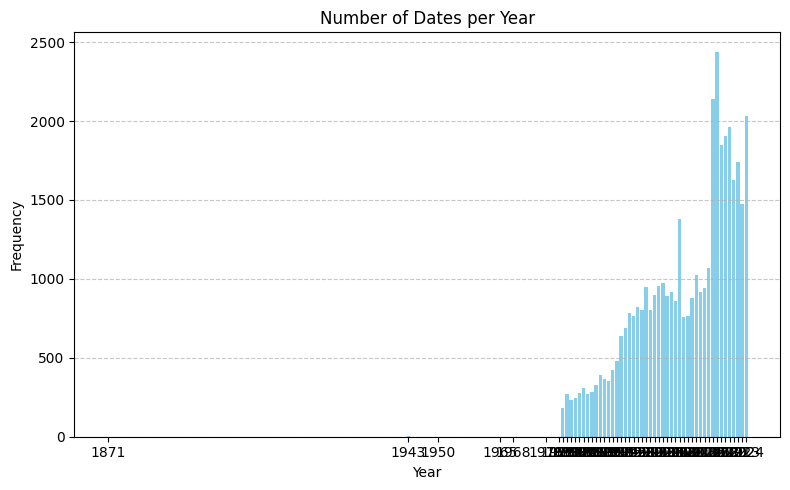

In [7]:
import matplotlib.pyplot as plt
from collections import Counter

# Group by year
years = [d.year for d in parsed_dates]
year_counts = Counter(years)

# Sort by year
sorted_years = sorted(year_counts)
frequencies = [year_counts[year] for year in sorted_years]

# Plot
plt.figure(figsize=(8, 5))
plt.bar(sorted_years, frequencies, color='skyblue')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Number of Dates per Year')
plt.xticks(sorted_years)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [8]:
years_list = [key for key,value in year_counts.items() if value > 2]

In [9]:
min(years_list)

1980

In [10]:
min([i for i in parsed_dates if i.year == 1980])

Timestamp('1980-06-01 00:00:00')

### Data issue 1: Working-class keyworks not in the body

In [11]:
# working-class or working class present
working_class_df = df[[('working-class' in str(i).lower()) or ('working class' in str(i).lower()) for i in df['body_cleaned']]]

In [12]:
# percetnage time missing
fraction_missing = (df.shape[0] - working_class_df.shape[0]) / df.shape[0]
if fraction_missing > 0:
    print("Data issue: {}% of articles don't include the working class keyworks.".format(round(fraction_missing*100,2)))
else:
    print("Issue resolved.")

Data issue: 4.05% of articles don't include the working class keyworks.


### Data issue 2: Anomaly with articles' titles

In [13]:
anomalous_titles = {key:value for key, value in dict(df['title'].value_counts()).items() if value > 100}
anomalous_titles

{'The New York Times': np.int64(1971),
 'Final Edition': np.int64(1024),
 'Metro Edition': np.int64(564),
 'First Edition': np.int64(240),
 'Sooner Edition': np.int64(188)}

In [14]:
fraction_anomalous_titles = sum(anomalous_titles.values()) / df.shape[0]
if fraction_anomalous_titles > 0:
    print("Data issue: {}% of articles have suspicious titles.".format(round(fraction_anomalous_titles*100,2)))
else:
    print("Issue resolved.")

Data issue: 9.71% of articles have suspicious titles.


### Data issue 3: Repetition of Very Similar Articles

__Question:__ Should only one be selected if the body similarity score is above a certain threshold?

See example below.

In [15]:
#{key:value for key,value in dict(df['title'].value_counts()).items() if value in [2,3]}

In [16]:
df.loc[df["title"] == "Voters Guide: Crossman Vs. Yost In Race For Ohio Attorney General"]

,title,date,section,length,body,source_file,publisher,publish_date,edition,section_info,author,url,body_cleaned,year
28619,Voters Guide: Crossman Vs. Yost In Race For Oh...,"October 17, 2022",Local,1732 words,all candidates local state office sent same se...,Files (500) (4).DOCX,Other publishers,"October 17, 2022",NaN,Local,NaN,NaN,all candidates for local state office were sen...,2022.0
28626,Voters Guide: Crossman Vs. Yost In Race For Oh...,"October 13, 2022",Local,1723 words,all candidates local state office sent same se...,Files (500) (4).DOCX,Other publishers,"October 13, 2022",NaN,Local,NaN,NaN,all candidates for local state office were sen...,2022.0
31962,Voters Guide: Crossman Vs. Yost In Race For Oh...,"October 7, 2022",Local,821 words,all candidates local state office sent same se...,Files (500) (3).DOCX,Other publishers,"October 7, 2022",NaN,Local,NaN,NaN,all candidates for local state office were sen...,2022.0


<a id="cleaning-and-sampling-temporary-section"></a>

## 3. Cleaning and Sampling (Temporary Section)

Processing only a subset of the data while finalizing methods and dataset.

[⬆ Return to Top](#table-of-contents)

In [17]:
# take article with a clean title
acceptable_titles = {key:value for key, value in dict(df['title'].value_counts()).items() if value == 1}
df_clean_title = df.loc[df['title'].isin(acceptable_titles)]
print(f"Number of dropped articles {df.shape[0] - df_clean_title.shape[0]}, out of {df.shape[0]}.")

Number of dropped articles 6281, out of 41056.


In [18]:
# drop articles with no working-class mention in either body or title
title_and_body = [(str(i).lower() + " " + str(j)) for i, j in zip(df_clean_title["title"], df_clean_title["body_cleaned"])]
working_class_bool = [('working-class' in i) or ('working class' in i) for i in title_and_body]
df_clean = df_clean_title.loc[working_class_bool]
print(f"Number of dropped articles {df_clean_title.shape[0] - df_clean.shape[0]}, out of {df_clean_title.shape[0]}.")
print(f"Remaining articles: {df_clean.shape[0]}")

Number of dropped articles 1413, out of 34775.
Remaining articles: 33362


In [19]:
# split by publisher
set(df['publisher'])

{'Other publishers', 'The New York Times'}

In [20]:
df_nyt = df_clean.loc[df_clean['publisher'] == 'The New York Times']
df_other = df_clean.loc[df_clean['publisher'] == 'Other publishers']

In [21]:
print(f"Number of New York Times articles: {df_nyt.shape[0]}")
print(f"Number of other publishers articles: {df_other.shape[0]}")

Number of New York Times articles: 25710
Number of other publishers articles: 7652


In [22]:
# random sample of 200 articles
sample_size = 200
df_nyt_sample = df_nyt.sample(sample_size)

<a id="processing-of-a-single-article"></a>

## 4. Processing of a Single Article

[⬆ Return to Top](#table-of-contents)

### Methods

In [23]:
from openai import OpenAI
import json

In [24]:
system_prompt = """
The user will provide a newspaper article about a specific segment of the working class. Using information from the article, answer the following questions **focusing exclusively on the characteristics of the working class group** described. Do not include information about other groups, even if they interact with or are discussed alongside the working class. If any information is missing or cannot be reasonably inferred, respond with "NA."

1) **Geographical Location** – Where is this working-class group located? (List all relevant U.S. states, or, if outside the U.S., list the countries.)

2) **Occupations** – What kinds of jobs does this working-class group hold? (List all that apply. Example categories include: Skilled Trades and Manual Labor, Manufacturing and Industrial Jobs, Service and Maintenance, Transportation and Delivery, Food Service, Retail and Customer Service, Health and Personal Care.)

3) **Race/Ethnicity** – What racial or ethnic backgrounds are identified for this working-class group?

4) **Gender** – What is the gender composition of the working-class group?

5) **Other Characteristics** – What other relevant characteristics are mentioned about the working-class group? (Examples: education level, union membership, income level, immigration status, age, etc.)
"""

In [25]:
response_format = {
  "type": "json_schema",
  "json_schema": {
    "name": "working_class_article_analysis",
    "schema": {
      "type": "object",
      "properties": {
        "geographical_locations": {
          "type": "array",
          "description": "Geographical location(s) of the working-class group discussed in the article (e.g., specific states or countries). If not provided or unclear, enter 'NA'.",
          "items": {
            "type": "string"
          },
          "minItems": 1
        },
        "occupations": {
          "type": "array",
          "description": "A list of occupation categories relevant to the group (e.g., 'Skilled Trades and Manual Labor', 'Food Service'). If not mentioned, use ['NA'] as the sole entry.",
          "items": {
            "type": "string"
          },
          "minItems": 1
        },
        "race_ethnicity": {
          "type": "string",
          "description": "Racial or ethnic background(s) identified in the article. If not mentioned, enter 'NA'."
        },
        "gender": {
          "type": "string",
          "description": "Gender composition of the group (e.g., 'Mostly women', 'Mixed', 'NA'). If not specified, enter 'NA'."
        },
        "other_characteristics": {
          "type": "string",
          "description": "Any additional relevant details (e.g., education level, union status, income level, immigration status, age). Enter 'NA' if none are provided."
        }
      },
      "required": [
        "geographical_locations",
        "occupations",
        "race_ethnicity",
        "gender",
        "other_characteristics"
      ],
      "additionalProperties": False
    },
    "strict": True
  }
}

In [26]:
def analyze_working_class(user_prompt):
    client = OpenAI()
    response = client.chat.completions.create(
        model="gpt-4.1",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ],
        response_format=response_format,
        temperature=0
    )

    return json.loads(response.choices[0].message.content)

### Example Article

In [27]:
user_prompt = "Title: {}.\n\nBody: {}".format(df["title"].iloc[1], df["body_cleaned"].iloc[1])
print(user_prompt)

Title: A Real Working-Class Hero.

Body: one of more moving stories in times this week an account of life of brian thompson, united healthcare chief executive who was gunned down on dec. 4 outside of a midtown manhattan hotel. thompson ''grew up in a working-class family in jewell, iowa,'' a tiny farming community north of des moines, amy julia harris ernesto londoño report. ''his mother was a beautician, according to family friends, his father worked at a facility to store grain.'' thompson's childhood was spent ''going row by row through fields to kill weeds with a knife, or working manual labor at turkey hog farms.'' those details worth bearing in mind as some people seek to cast his killing as a tale of justified, or at least understandable, fury against faceless corporate greed. one ex-times reporter, taylor lorenz, she felt ''joy'' at killing. elizabeth warren, massachusetts senator, offered that ''violence never answer'' but ''people can only be pushed so far.'' pictures of luig

In [28]:
response_dict = analyze_working_class(user_prompt)
response_dict

{'geographical_locations': ['Iowa'],
 'occupations': ['Skilled Trades and Manual Labor',
  'Agricultural Work',
  'Service and Maintenance'],
 'race_ethnicity': 'NA',
 'gender': 'NA',
 'other_characteristics': 'Grew up in a working-class family; mother was a beautician; father worked at a grain storage facility; worked manual labor in fields and on turkey and hog farms; from a small farming community (Jewell, Iowa); did not have wealthy parents or an Ivy League degree.'}

<a id="plots-of-nyt-sample-results"></a>

## 5. Plots of NYT Sample Results

[⬆ Return to Top](#table-of-contents)

In [29]:
# process the data

def generate_responses(df):
    responses = []
    for _, row in df.iterrows():
        user_prompt = f"Title: {row['title']}.\n\nBody: {row['body_cleaned']}"
        response = analyze_working_class(user_prompt)
        responses.append(response)
    return pd.DataFrame(responses)

In [30]:
# Reset index
df_nyt_sample.reset_index(drop=True, inplace=True)

# Generate responses
df_responses_nyt = generate_responses(df_nyt_sample)

In [31]:
# plots
import matplotlib.pyplot as plt
from collections import Counter

def plot_histogram(items_list, title, filename):
    # Count frequencies and sort from most to least frequent
    counter = Counter(items_list)
    sorted_items = sorted(counter.items(), key=lambda x: x[1], reverse=True)

    # Extract filtered labels and frequencies
    labels, frequencies = zip(*sorted_items)

    # Create the histogram
    plt.figure(figsize=(24, 8))
    plt.bar(labels, frequencies, color='skyblue')
    #plt.xlabel(xlabel, fontsize=18)
    plt.ylabel('Counts', fontsize=18)
    plt.title(title, fontsize=22)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45, ha='right', fontsize=18)
    plt.yticks(fontsize=18)
    plt.tight_layout()

    # Save to file
    plt.savefig(filename, dpi=300, facecolor='white', edgecolor='none')

    # Show the plot
    plt.show()

In [32]:
# categorize results
import ast

racial_categories = ["White", "Black or African American", "American Indian or Alaska Native", "Asian", "Native Hawaiian or Other Pacific Islander", "Mixed / Multiple"]
ethnic_categories = ["Hispanic", "Latino", "Not Hispanic or Latino"]
gender_categories = ["Mostly Women", "Mostly Men", "Mixed", "Nonbinary"]
#racial_ethnic_categories = racial_categories + ethnic_categories


def categorize_descriptors(race_ethnicity_list, category_list):
    
    categories_str = ", ".join(category_list)
    system_prompt_race_ethnicity_categorization = (
        f"Categorize each item in the user-provided Python list into one of the following categories: "
        f"{categories_str}. Return only a Python list as output. If cannot be categorized use 'NA'"
    )

    client = OpenAI()
    response = client.chat.completions.create(
        model="gpt-4.1",
        messages=[
            {"role": "system", "content":system_prompt_race_ethnicity_categorization},
            {"role": "user", "content": race_ethnicity_list}
        ],
        temperature=0
    )

    return ast.literal_eval(response.choices[0].message.content)

### Location

In [33]:
# Set of U.S. states
us_states = {
    'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut',
    'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa',
    'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan',
    'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
    'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio',
    'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
    'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia',
    'Wisconsin', 'Wyoming'
}

# Function to split states and countries
def split_locations(locations):
    states = [loc for loc in locations if loc in us_states]
    countries = [loc for loc in locations if loc not in us_states and loc != "United States"]
    return states, countries

# Flatten and filter location lists
def flatten_and_filter(locations_column):
    return [item for sublist in locations_column for item in sublist if item != "NA"]

# Get and process NYT locations
locations_nyt = flatten_and_filter(df_responses_nyt["geographical_locations"])
print(f"NYT total locations: {len(locations_nyt)}")

states_nyt, countries_nyt = split_locations(locations_nyt)

NYT total locations: 363


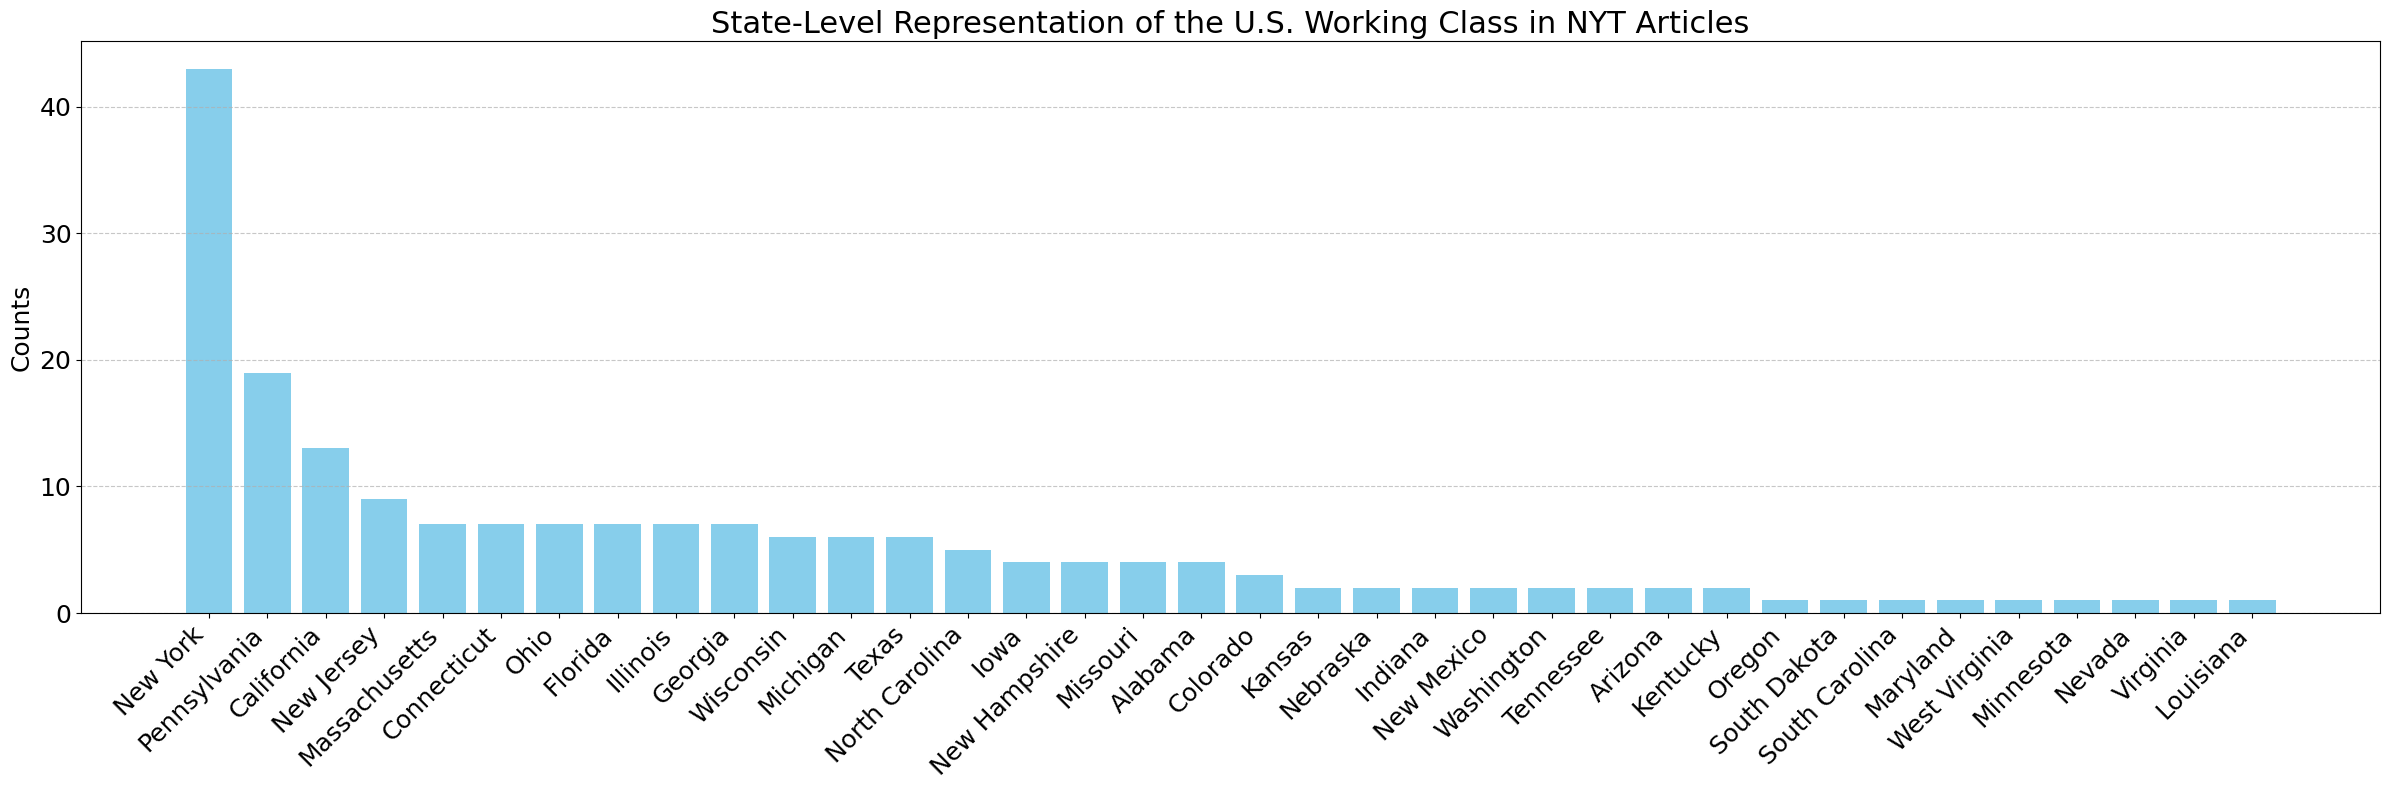

In [34]:
#xlabel = 'U.S. State'
title = "State-Level Representation of the U.S. Working Class in NYT Articles"
filename = 'plots/histogram_states_nyt.png'
plot_histogram(states_nyt, title, filename)

In [35]:
#xlabel = "Country"
#title = "International Coverage of the Working Class in NYT Articles (Excluding U.S.)" 
#filename = "plots/histogram_countries_nyt.png"
#plot_histogram(countries_nyt, xlabel, title, filename)

### Occupation

In [36]:
occupation_categories = ["Skilled Trades and Manual Labor", "Manufacturing and Industrial Jobs", "Service and Maintenance", "Transportation and Delivery", "Food Service", "Retail and Customer Service", "Health and Personal Care", "Education", "Domestic Work", "Professional Services", "Other"]

In [37]:
occupations_nyt = list(df_responses_nyt["occupations"])
occupations_nyt = [item for sublist in occupations_nyt for item in sublist if item != "NA"]
occupations_nyt = categorize_descriptors(str(occupations_nyt), occupation_categories)
occupations_nyt = [i if i in occupation_categories else "Other" for i in occupations_nyt]

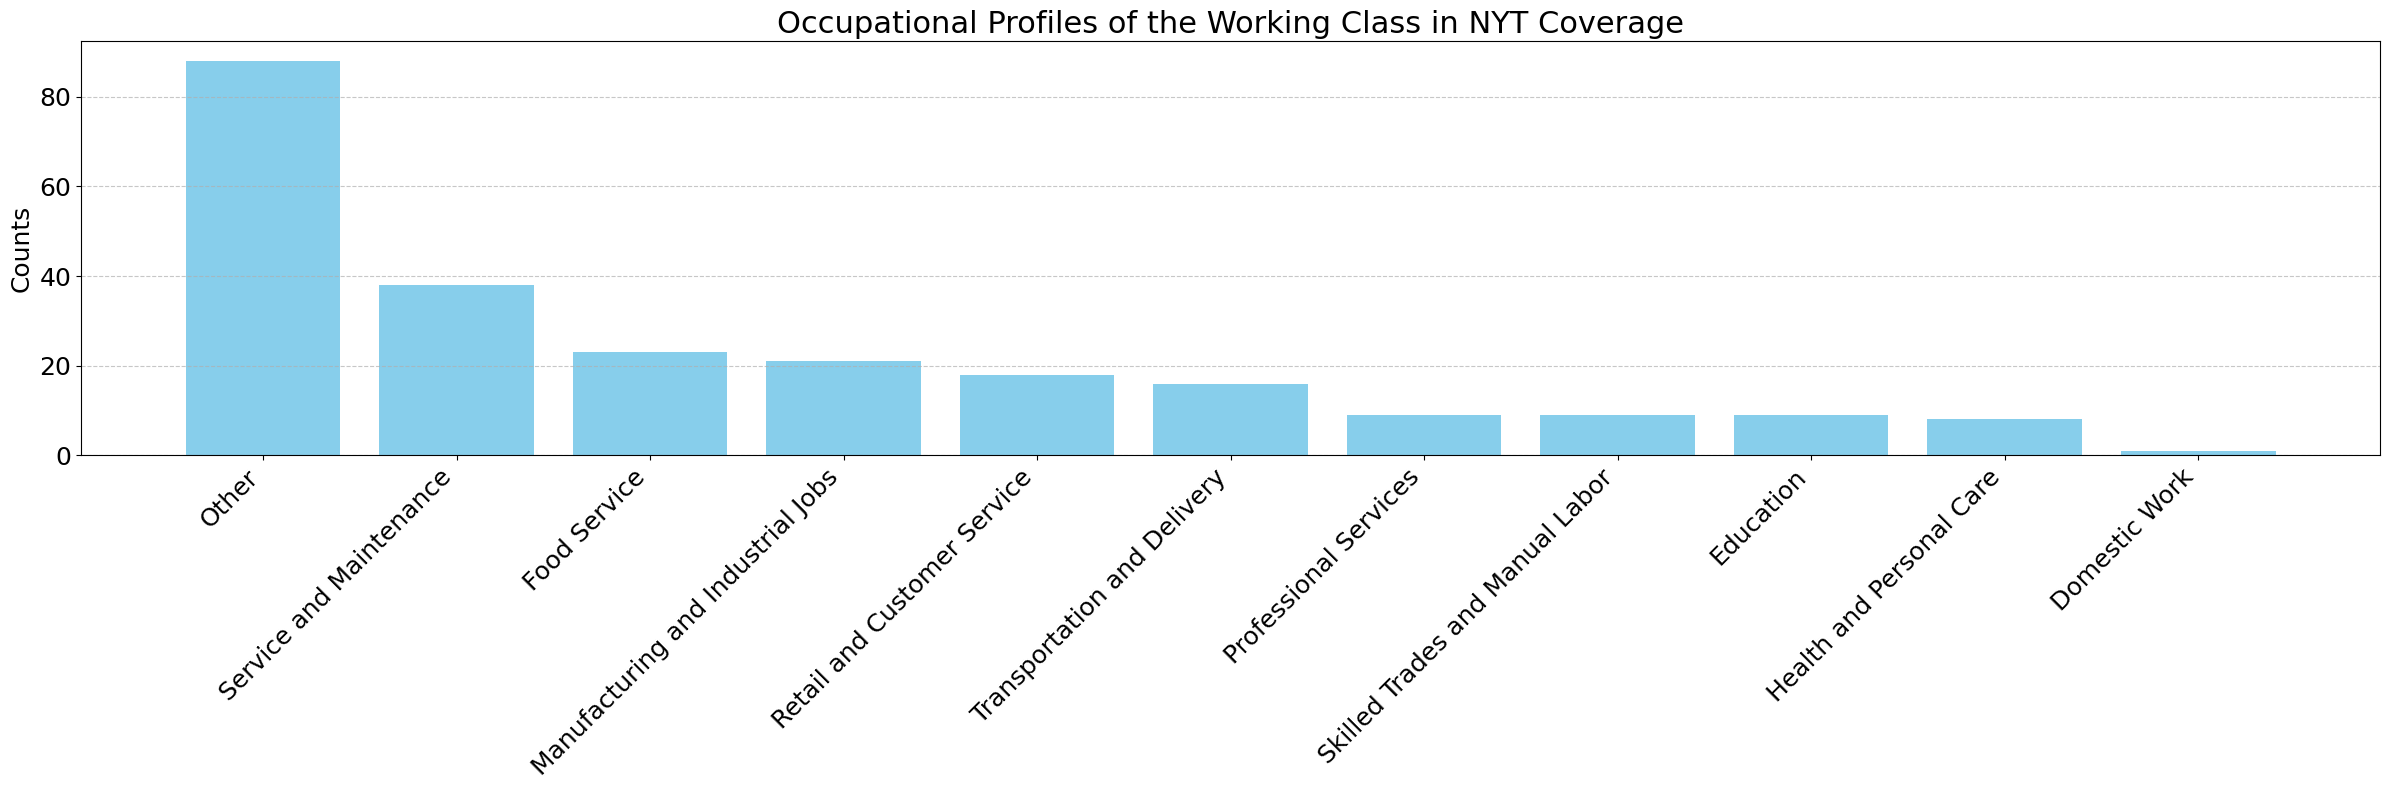

In [38]:
#xlabel = "Occupation"
title = "Occupational Profiles of the Working Class in NYT Coverage"
filename = "plots/histogram_occupations_nyt.png"
plot_histogram(occupations_nyt, title, filename)

### Race and ethnicity

In [39]:
def extract_race_ethnicity(df):
    # Extract and filter out "NA" strings
    race_ethnicity = df["race_ethnicity"].dropna()
    race_ethnicity = [resp for resp in race_ethnicity if resp != "NA"]
    
    # Categorize race and ethnicity
    race = categorize_descriptors(str(race_ethnicity), racial_categories)
    ethnicity = categorize_descriptors(str(race_ethnicity), ethnic_categories)

    # Filter out "NA" results from categorization
    race = [r for r in race if r != "NA"]
    ethnicity = [e for e in ethnicity if e != "NA"]

    return race, ethnicity

race_nyt, ethnicity_nyt = extract_race_ethnicity(df_responses_nyt)


In [40]:
#xlabel = "Race / Ethnicity"
#title = "Race / Ethnicity of Working-Class Coverage in NYT Articles"
#filename = "plots/histogram_race_ethnicity_nyt.png"
#plot_histogram(race_ethnicity, xlabel, title, filename)

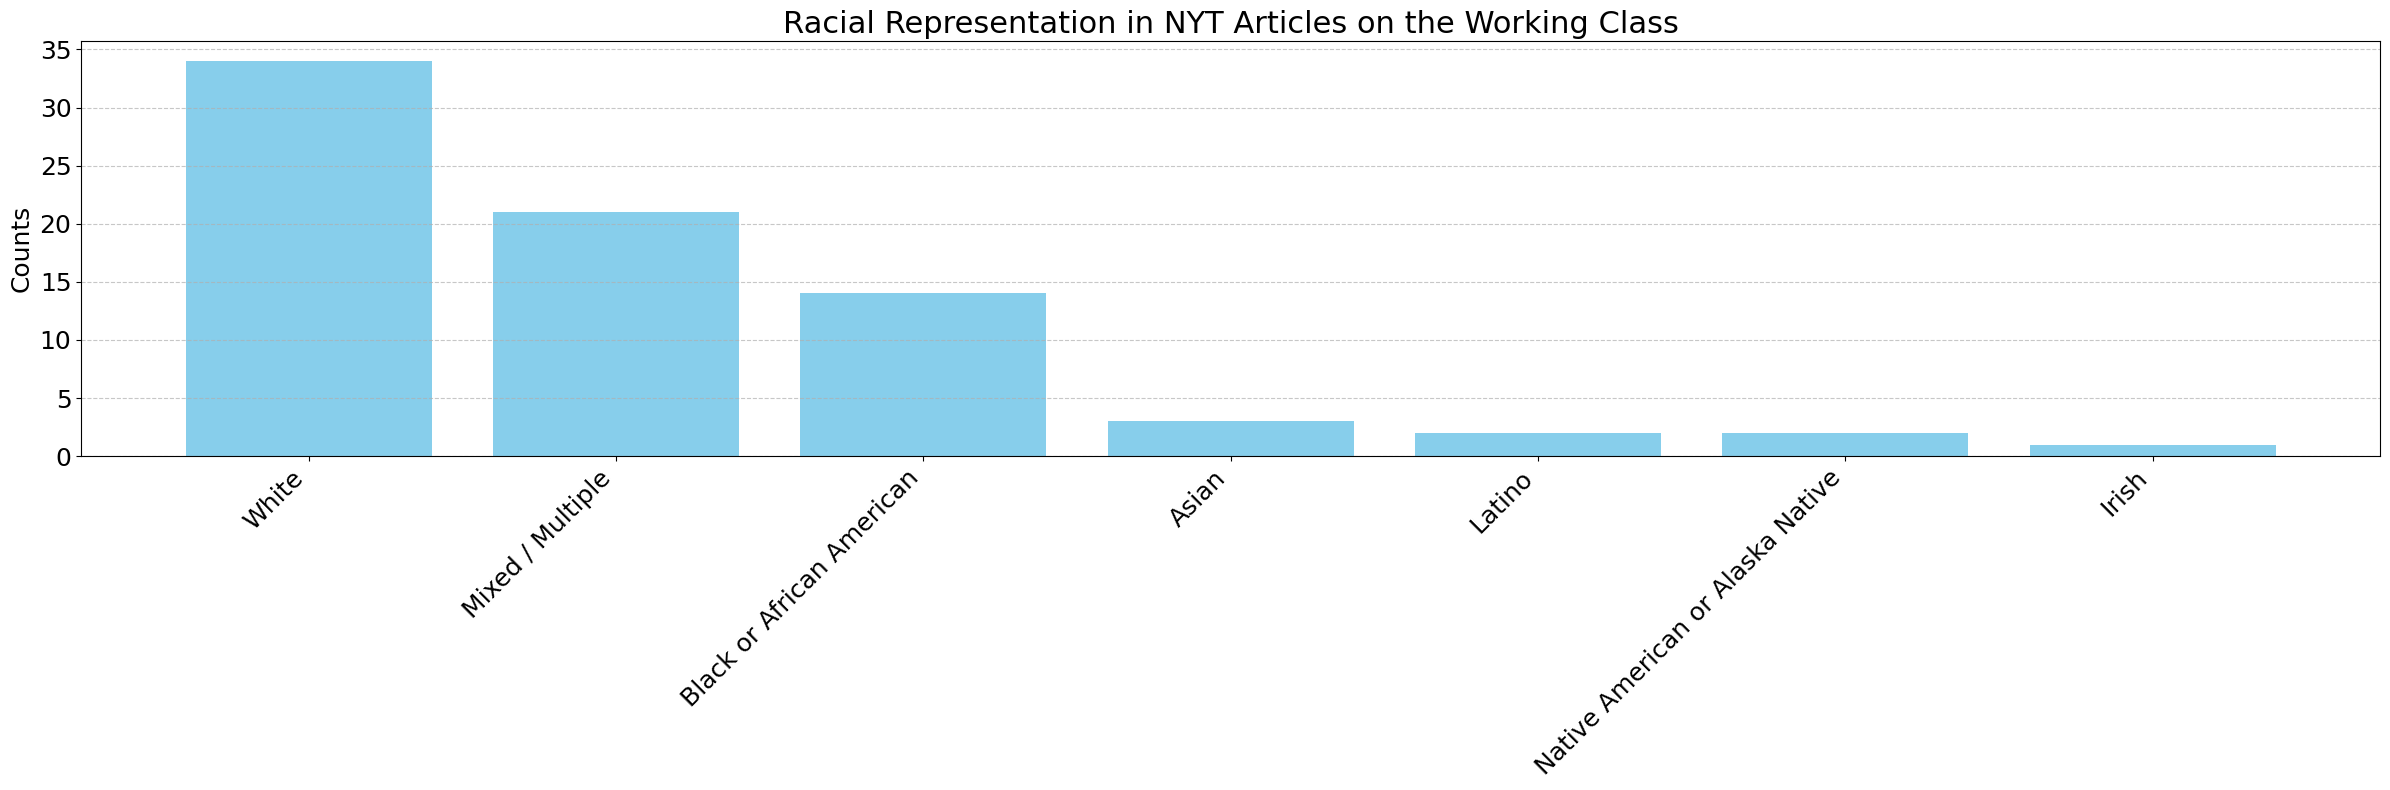

In [41]:
#xlabel = "Race"
title = "Racial Representation in NYT Articles on the Working Class"
filename = "plots/race_category_nyt.png"
plot_histogram(race_nyt, title, filename)

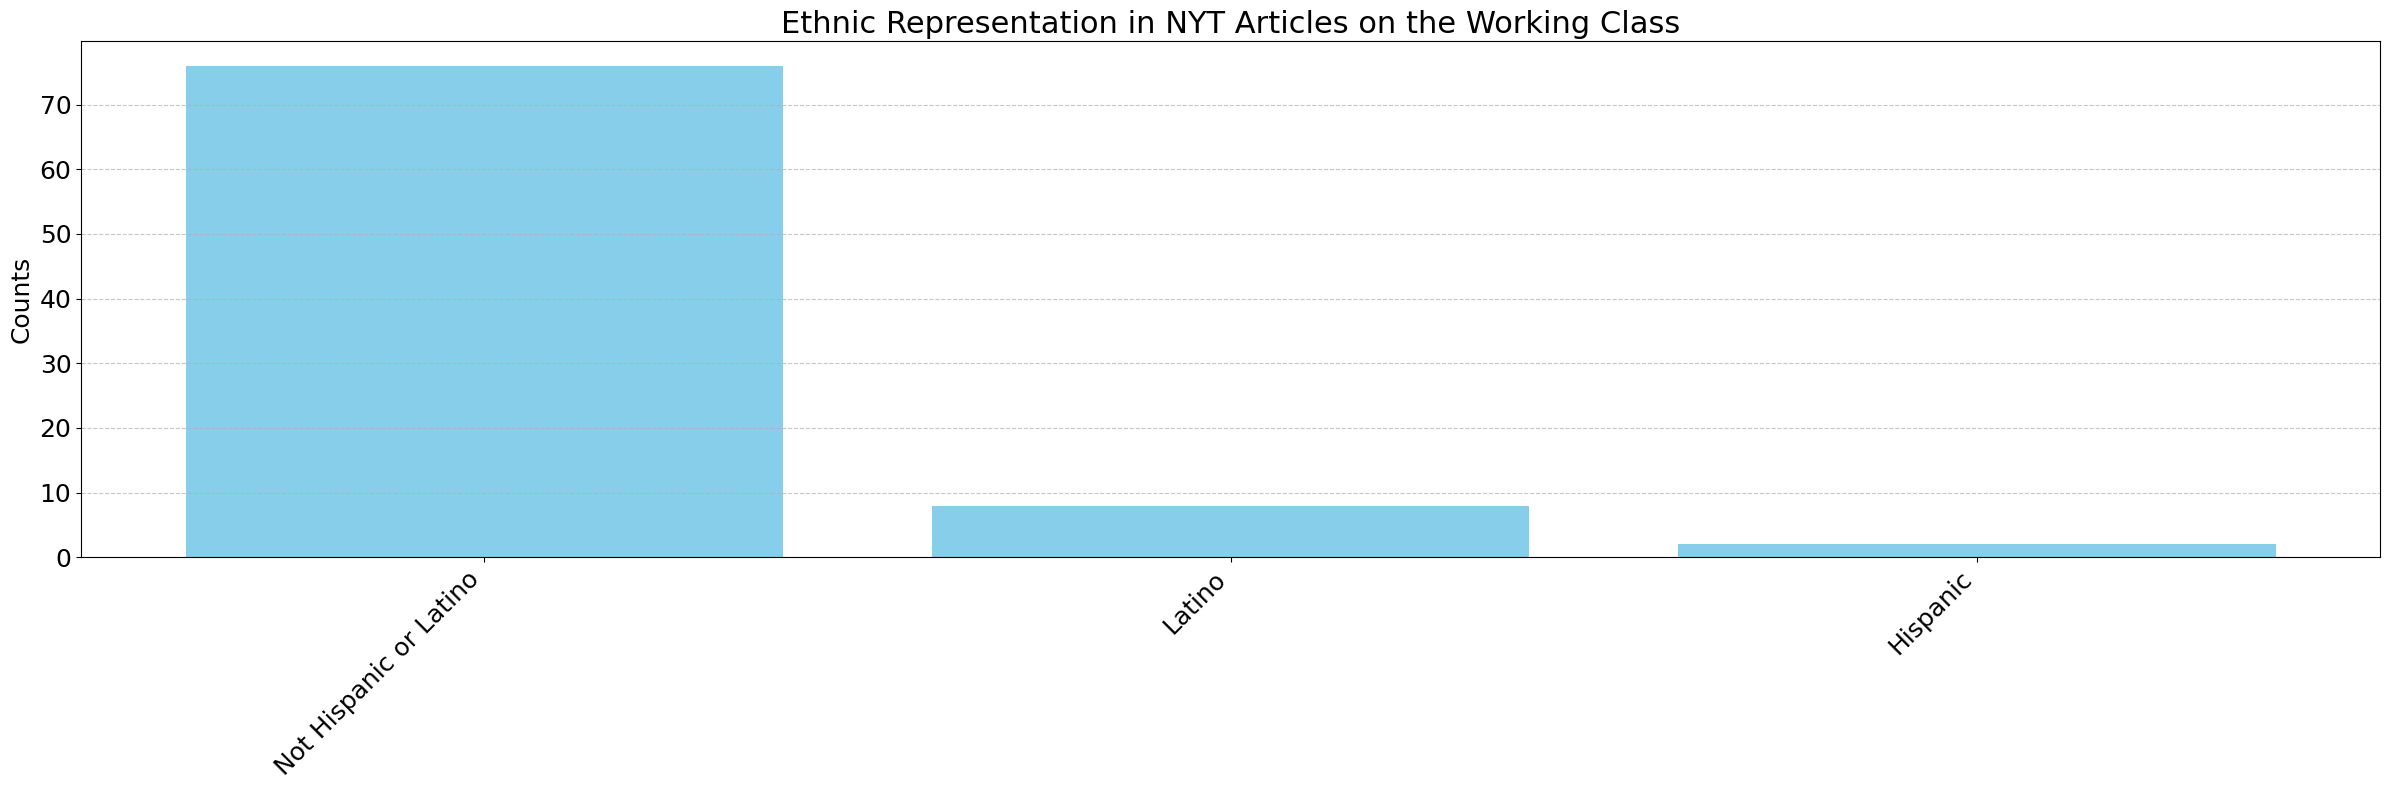

In [42]:
#xlabel = "Ethnicity"
title = "Ethnic Representation in NYT Articles on the Working Class"
filename = "plots/ethnicity_category_nyt.png"
plot_histogram(ethnicity_nyt, title, filename)

### Gender

In [43]:
gender_nyt = list(df_responses_nyt["gender"])
gender_nyt = [item for item in gender_nyt if item != "NA"]
gender_nyt = categorize_descriptors(str(gender_nyt), gender_categories)

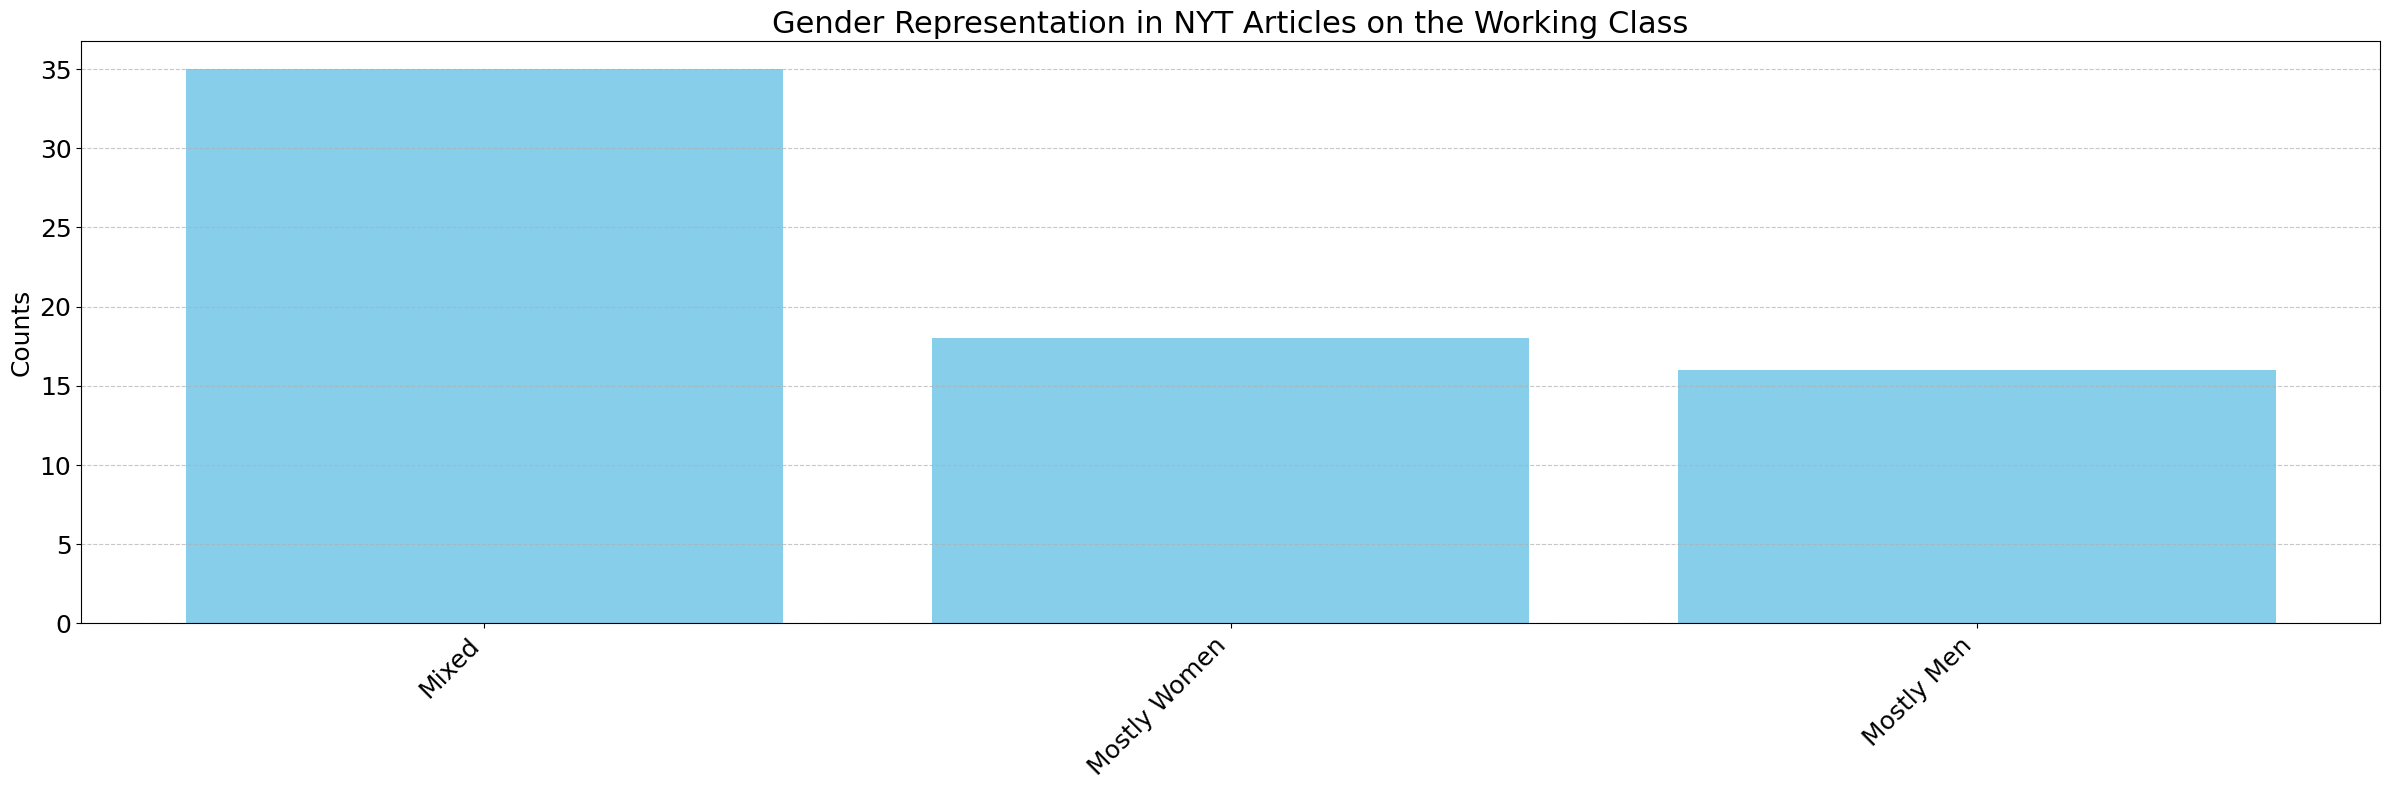

In [44]:
#xlabel = "Gender"
title = "Gender Representation in NYT Articles on the Working Class"
filename = "plots/gender_category_nyt.png"
plot_histogram(gender_nyt, title, filename)

### Other Characteristics

In [45]:
other = [i for i in list(df_responses_nyt["other_characteristics"]) if i != "NA"]
other_str = " ".join(other)

In [46]:
#!pip install wordcloud matplotlib
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_wordcloud(items_list, title, filename):

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(other_str)

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off axes
    plt.title(title, fontsize=20)
    plt.savefig(filename, dpi=300, facecolor='white', edgecolor='none')
    plt.show()

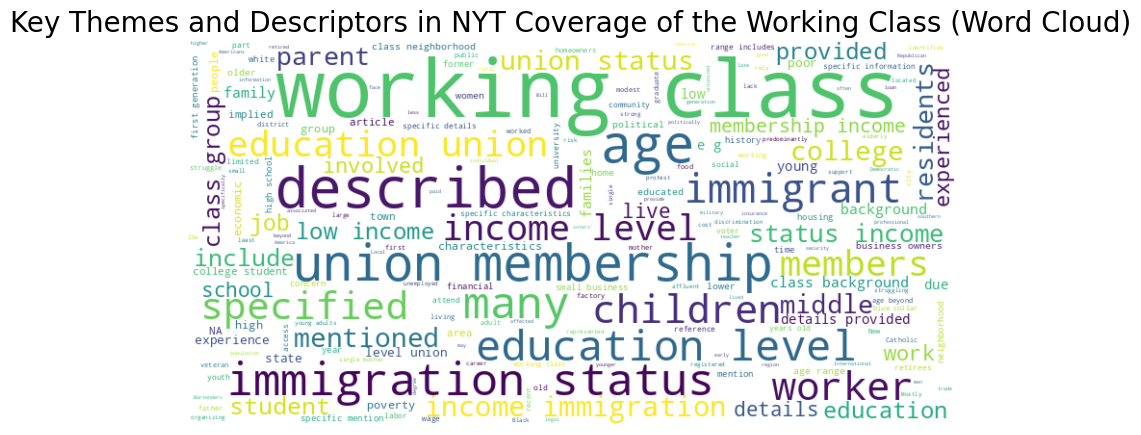

In [47]:
title = "Key Themes and Descriptors in NYT Coverage of the Working Class (Word Cloud)"
filename = "plots/wordcloud_additional_characteristics_nyt.png"
plot_wordcloud(other_str, title, filename)

<a id="comparison-with-other-publishers"></a>

## 6. Comparison with Other Publishers


[⬆ Return to Top](#table-of-contents)

In [ ]:
# generate results dataframe
df_other_sample = df_other.sample(sample_size)

# Reset index
df_other_sample.reset_index(drop=True, inplace=True)

# Generate responses
df_responses_other = generate_responses(df_other_sample)

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

def compare_histograms(items_list1, items_list2, title, filename, label1='List 1', label2='List 2'):
    # Count frequencies
    counter1 = Counter(items_list1)
    counter2 = Counter(items_list2)

    # Get all unique labels
    all_labels = sorted(set(counter1.keys()).union(set(counter2.keys())))

    # Get frequencies for each label (0 if not present)
    freq1 = [counter1.get(label, 0) for label in all_labels]
    freq2 = [counter2.get(label, 0) for label in all_labels]

    # Set positions for bars
    x = np.arange(len(all_labels))
    width = 0.4  # width of the bars

    # Create the grouped bar chart
    plt.figure(figsize=(24, 8))
    plt.bar(x - width/2, freq1, width, label=label1, color='skyblue')
    plt.bar(x + width/2, freq2, width, label=label2, color='salmon')

    # Formatting
    #plt.xlabel(xlabel, fontsize=18)
    plt.ylabel('Counts', fontsize=18)
    plt.title(title, fontsize=22)
    plt.xticks(x, all_labels, rotation=45, ha='right', fontsize=18)
    plt.yticks(fontsize=18)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(fontsize=18)
    plt.tight_layout()

    # Save and show
    plt.savefig(filename, dpi=300, facecolor='white', edgecolor='none')
    plt.show()


### Location

In [ ]:
# Get and process Other source locations
locations_other = flatten_and_filter(df_responses_other["geographical_locations"])
print(f"Other total locations: {len(locations_other)}")

# Split locations
states_other, countries_other = split_locations(locations_other)

In [ ]:
#xlabel = 'U.S. State'
title = 'State-Level Representation of the U.S. Working Class: NYT vs. Other Publishers'
filename = "plots/comparison_states.png"
compare_histograms(states_nyt, states_other, title, filename, label1='The New York Times', label2='Other Publishers')

### Occupation

In [ ]:
occupations_other = list(df_responses_other["occupations"])
occupations_other = [item for sublist in occupations_other for item in sublist if item != "NA"]
occupations_other = categorize_descriptors(str(occupations_other), occupation_categories)
occupations_other = [i if i in occupation_categories else "Other" for i in occupations_other]

In [ ]:
#xlabel = 'Occupation'
title = 'Occupational Profiles in Working-Class Coverage: NYT vs. Other Publishers'
filename = "plots/comparison_occupation.png"
compare_histograms(occupations_nyt, occupations_other, title, filename, label1='The New York Times', label2='Other Publishers')

### Race & Ethnicity

In [ ]:
race_other, ethnicity_other = extract_race_ethnicity(df_responses_other)

In [ ]:
#xlabel = 'Race'
title = 'Racial Representation in Working-Class Coverage: NYT vs. Other Publishers'
filename = "plots/comparison_race.png"
compare_histograms(race_nyt, race_other, title, filename, label1='The New York Times', label2='Other Publishers')

In [ ]:
#xlabel = 'Ethnicity'
title = 'Ethnic Representation in Working-Class Coverage: NYT vs. Other Publishers'
filename = "plots/comparison_ethnicity.png"
compare_histograms(ethnicity_nyt, ethnicity_other, title, filename, label1='The New York Times', label2='Other Publishers')

### Gender

In [ ]:
gender_other = list(df_responses_other["gender"])
gender_other = [item for item in gender_other if item != "NA"]
filename = "plots/comparison_gender.png"
gender_other = categorize_descriptors(str(gender_other), gender_categories)

In [ ]:
#xlabel = 'Gender'
title = 'Ethnic Representation in Working-Class Coverage: NYT vs. Other Publishers'
compare_histograms(gender_nyt, gender_other, title, filename, label1='The New York Times', label2='Other Publishers')

### Other characteristics

In [ ]:
other = [i for i in list(df_responses_other["other_characteristics"]) if i != "NA"]
other_str = " ".join(other)

In [ ]:
title = "Key Themes and Descriptors in Non-NYT Coverage of the Working Class (Word Cloud)"
filename = "plots/wordcloud_additional_characteristics_other.png"
plot_wordcloud(other_str, title, filename)

<a id="next-steps"></a>

# 7. Next Steps


[⬆ Return to Top](#table-of-contents)


TO DO:

* Read background reseach in Google Drive

* Troubleshoot data issues

* Confirm approach and methods with Elena

* Expand to entire dataset

* Clean code

* Add notebook descriptions

Open questions:

* See data issues

* Adjust domains, categories for domains, prompts?

* Analyze historical patterns to understand if media coverage has shifted over time?



<a id="troubleshooting"></a>

## 8. Troubleshooting

[⬆ Return to Top](#table-of-contents)

### Investigate Specific Cases

In [40]:
idx = 4
user_prompt = "Title: {}.\n\nBody: {}".format(df_nyt_sample["title"].iloc[idx], df_nyt_sample["body_cleaned"].iloc[idx])
print(user_prompt)

Title: HERS.

Body: at age of 27 i became head foreign-exchange options trader at a major commercial bank in new york. i managed hundreds of millions of dollars' worth of options. i ran offices in new york london. it was a powerful demanding position. few women have had this experience, so i am often asked what it was like to work in a bank trading room on wall street. i like to tell following story: it was a cold day in early february, almost a year to day since i had started my trading career. we'd had an unusually hectic morning, i was sitting at my desk, frantically trying to calculate effect of morning's trades on overall position. this had to be done quickly accurately. i was lost in concentration when suddenly i noticed that there was something wrong. it took me a second or two to realize what was matter. room had gone completely quiet. during entire year i had been trading, i had never experienced so complete a silence. instinctively, i glanced at reuters screen. currency price

In [ ]:
response_dict = analyze_working_class(user_prompt)
response_dict

### Example issues

In [49]:
df.iloc[46]['body_cleaned']

'jumpsuit. upgrade to an (on-sale) electric toothbrush. browse these deals on great host gifts. games here today’s spelling bee. yesterday’s pangram was handbill. here today’s mini crossword, wordle, sudoku, connections strands. thanks for spending part of your morning with times. see you tomorrow. —david sign up here to get this newsletter in your inbox. reach our team at themorning@nytimes.com. photo: barack obama in 2007. (photograph by keith bedford for new york times for new york times)'

In [50]:
df.iloc[46]

title                                   Barack Obama’s Big Lesson
date                                            November 26, 2024
section                                                  BRIEFING
length                                                       2008
body            jumpsuit. upgrade (-sale) electric toothbrush....
source_file                                                1.DOCX
publisher                                      The New York Times
publish_date                                    November 26, 2024
edition                                                       NaN
section_info                                             BRIEFING
author                                                        NaN
url                                                           NaN
body_cleaned    jumpsuit. upgrade to an (on-sale) electric too...
year                                                       2024.0
Name: 46, dtype: object

In [22]:
df.iloc[129]['body']

'— my work private citizen come january — work unfinished.” photo: senator sherrod brown, who once considered potential presidential candidate, received encouragement democratic colleagues try come back senate two midterms. (photograph haiyun jiang york york )'

In [26]:
df.iloc[171]['body']

'’s finance committee.. trump’s inauguration, senate plans introduce fleet bills related protecting reproductive rights, including one. krueger protect women’s health information another increase funding training medical providers how perform abortions. “ privacy issue becomes more relevant we sink la-la land administration congress who want encourage women die states they cannot get abortion proper health care,”. krueger, pointing texas attorney general’s recent lawsuit against york doctor prescribing abortion pills woman dallas.. stewart-cousins, democrat, statement voters expect elected forcefully stand up. trump again “ continue make child care college tuition more affordable, help families afford groceries, pay utility bills lower costs prescription drugs.” senator michael gianaris, deputy majority leader, affordability push also most likely see state lawmakers take big tech regulate artificial intelligence products. also bill update state’s enforcement antitrust laws, which likel

# Notes

__Definitions__

Oxford definition: "the socioeconomic group consisting of people who are employed in manual or industrial work."

Oxford definition of industry: "economic activity concerned with the processing of raw materials and manufacture of goods in factories."


__Key Dimensions to Consider__

* Geographical Location: Often associated with regions like the Midwest in U.S. discourse.

* Occupation: Typically involve manual labor, skilled trades, or service industry work, and often do not require a four-year college degree.

    * Skilled Trades and Manual Labor
    
    * Manufacturing and Industrial Jobs
    
    * Service and Maintenance Jobs
    
    * Transportation and Delivery
    
    * Food Service
    
    * Retail and Customer Service
    
    * Health and Personal Care

* Race: Representation may differ across media and historical narratives.

* Gender: Varies by industry and media portrayal.

* Other Possible Factors:

    * Education level
    
    * Union membership
    
    * Income level
    
    * Immigration status

__Media Representations__

* New York Times

    * May assume the working class = white men in industrial jobs.

* Black Newspapers

    * Highlight working-class experiences of minorities and women.

    * Broader and more inclusive definition of the working class.